importing dabatabse from backend.py

In [3]:
from database import checkpointer

In [ ]:
from typing import TypedDict, List, Annotated, Optional, Dict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromsptTemplate
from langchain_core.messages import SystemMessage, HumanMessage

In [5]:
import sys
print(sys.executable)

c:\AYUSH\comet\ans\Scripts\python.exe


In [6]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [7]:
from typing import TypedDict, Optional, List, Dict

class JobAgent(TypedDict, total=False):
    # ---- Initial user input ----
    name: str
    job_title: str
    experience: int
    pdf_path: str
    jd: str
    email: Optional[str]
    linkedin: Optional[str]

    # ---- Generated during flow ----
    resume_text: str
    sections: Dict[str, str]
    missing_fields: List[str]

    # ---- LLM Output ----
    match: bool
    match_score: float
    overall_quality_score: float
    quality_verdict: str
    reason: str
    missing_improvements: List[str]
    missing_field_explanations: Dict[str, str]
    feedback_summary: str
    #adding refrence_reume links
    ref_resume: List[str]
    jobs_links: List[str]
    courses_list: List[str]
    

MAKING ALL THE FUNCTION DEFINED TO RE-MAP THE GRAPH

STEP 1 = EXTRACTION
#here we will load the pdf and extract all the 
#text and store in any list formate
#this function will return a string which is here text

In [8]:
from langchain_community.document_loaders import PyPDFLoader
def extraction(state : JobAgent) -> JobAgent:
    pdf_path = state["pdf_path"]
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()

    text = ""
    for doc in docs:
        text += doc.page_content + "\n"
    
    state["resume_text"] = text
    return state
    

STEP 2

In [9]:
import re
def preprocess(state : JobAgent) -> JobAgent:
    text = state.get("resume_text")
    headings = [
        "SUMMARY", "OBJECTIVE",
        "SKILLS", "TECHNICALSKILLS",
        "EDUCATION",
        "EXPERIENCE", "WORKEXPERIENCE",
        "PROJECTS", "PROJECT",
        "CERTIFICATIONS",
        "ACHIEVEMENTS",
        "INTERNSHIPS",
        "LANGUAGES"
    ]
    required_words = ["github", "gmail.com", "linkedin", "leetcode"]

    #cheking required
    missing = []
    lower_text = text.lower()
    
    for word in required_words:
        if word not in lower_text:
            missing.append(word)
    
    #section splitting
    sections = {"OTHER" : ""}
    current = "OTHER"

    for line in text.split("\n"):
        line = line.strip()
        if not line :
            continue

        normalised = re.sub(r"[^A-Za-z]", "", line).upper()

        if normalised in headings:
            current = normalised
            sections[current] = ""
        else :
            sections[current] += line + "\n"

    state["missing_fields"] = missing
    state["sections"] = sections
    
    return state
    


In [10]:
import json

def missing(state: JobAgent) -> JobAgent:
    try:
        
        job_title = state.get("job_title", "")
        sections = state.get("sections", {})
        missing_fields = state.get("missing_fields", [])

        summary = sections.get("SUMMARY", "")
        skills = sections.get("SKILLS", "") or sections.get("TECHNICALSKILLS", "")

       
        # ----------------------------
        # System Prompt
        # ----------------------------
        system_prompt = """
You are a strict and realistic technical recruiter.

Responsibilities:

1. Compare resume summary and skills with the job title.
2. Decide whether the resume matches the job.
3. Give a match score between 0 and 10 (higher = better alignment).

4. Give an overall quality score between 0 and 10:
   - 0 = Very poor resume
   - 10 = Excellent resume
   (Higher score means better quality)

IMPORTANT SCORING RULES:
- Missing required fields MUST reduce overall quality score.
- If GitHub, LinkedIn, Email, or LeetCode is missing,
  apply a clear negative impact.
- More missing fields = lower overall score.
- Be strict and realistic.

5. Classify quality as:
   - Poor (0-3)
   - Average (4-6)
   - Good (7-8)
   - Excellent (9-10)

6. If required fields are missing, explain clearly why they are important.

7. Provide short structured feedback using:
   ✅ for strengths
   ❌ for weaknesses

Return ONLY valid JSON.
Do not add explanation outside JSON.
"""

        # ----------------------------
        # Human Prompt
        # ----------------------------
        human_prompt = f"""
JOB TITLE:
{job_title}

RESUME SUMMARY:
{summary}

RESUME SKILLS:
{skills}

MISSING FIELDS DETECTED:
{missing_fields}

Return JSON in this exact structure:

{{
  "match": true/false,
  "match_score": number,
  "overall_quality_score": number,
  "quality_verdict": "Poor/Average/Good/Excellent",
  "reason": "short explanation",
  "missing_improvements": ["point1", "point2"],
  "missing_field_explanations": {{
        "field_name": "why this field is important"
  }},
  "feedback_summary": "4-6 short lines using ✅ and ❌"
}}
"""

        response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=human_prompt)
        ])

        content = response.content.strip()

        # ----------------------------
        # Safe JSON Parsing
        # ----------------------------
        try:
            parsed = json.loads(content)
        except json.JSONDecodeError:
            start = content.find("{")
            end = content.rfind("}") + 1
            parsed = json.loads(content[start:end])

        # ----------------------------
        # Deterministic Penalty Logic
        # (Ensures missing fields ALWAYS reduce score)
        # ----------------------------
        overall_score = float(parsed.get("overall_quality_score", 5))

        penalty = len(missing_fields) * 0.5
        overall_score = max(0, overall_score - penalty)

        # Recalculate verdict safely
        if overall_score <= 3:
            verdict = "Poor"
        elif overall_score <= 6:
            verdict = "Average"
        elif overall_score <= 8:
            verdict = "Good"
        else:
            verdict = "Excellent"

        # ----------------------------
        # Update State
        # ----------------------------
        state["match"] = parsed.get("match", False)
        state["match_score"] = float(parsed.get("match_score", 0))
        state["overall_quality_score"] = round(overall_score, 2)
        state["quality_verdict"] = verdict
        state["reason"] = parsed.get("reason", "")
        state["missing_improvements"] = parsed.get("missing_improvements", [])
        state["missing_field_explanations"] = parsed.get("missing_field_explanations", {})
        state["feedback_summary"] = parsed.get("feedback_summary", "")

        return state

    except Exception as e:
        # ----------------------------
        # Fail-Safe (Never Break Graph)
        # ----------------------------
        state["match"] = False
        state["match_score"] = 0
        state["overall_quality_score"] = 0
        state["quality_verdict"] = "Poor"
        state["reason"] = f"Evaluation failed: {str(e)}"
        state["missing_improvements"] = []
        state["missing_field_explanations"] = {}
        state["feedback_summary"] = "❌ Evaluation failed due to system error."

        return state

NODES

we can store all this info in cache and if in future 
the user give jd we will give me perceatge how fit he is or not

playright code

In [11]:
import os
from tavily import TavilyClient
api_key = os.getenv("TAVILY_API_KEY")
client = TavilyClient(api_key=api_key)

In [12]:
def resume_refrence(state : JobAgent) -> JobAgent:
    #search good resume
    title1 = state.get("job_title")
    query1 = f"{title1} best ats friendly resume 2026"
    response1 = client.search(
        query = query1,
        search_depth = "advanced",
        max_results=3,
        include_answer=False,
        include_raw_content=False,
    )
    # Ensure list exists
    if "ref_resume" not in state:
        state["ref_resume"] = []
    
    for r in response1.get("results", []):
        state["ref_resume"].append(r.get("url"))

    return state

In [13]:
def job_sites(state: JobAgent) -> JobAgent:

    title2 = state.get("job_title", "")

    query2 = [
        f'site:naukri.com "{title2}" fresher jobs',
        f'site:internshala.com "{title2}" fresher jobs',
        f'site:linkedin.com "{title2}" fresher jobs',
        f'site:glassdoor.co.in "{title2}" fresher jobs',
        f'site:instahyre.com "{title2}" fresher jobs',
    ]

    # Initialize safely
    state["jobs_links"] = []

    for q in query2:
        link = client.search(
            query=q,
            search_depth="advanced",
            max_results=1,
            include_answer=False,
            include_raw_content=False
        )

        for l in link.get("results", []):
            state["jobs_links"].append(l.get("url"))

    return state

In [14]:
def courses(state : JobAgent) -> JobAgent:
    title3 = state.get("job_title")
    query3= f"{title3} best online courses for placement india"
    response3 = client.search(
        query=query3,
        search_depth="advanced",
        max_results=5,
        include_answer=False,
        include_raw_content=False
    )
    
    if "courses_list" not in state:
        state["courses_list"] = []

    for r in response3.get("results", []):
        state["courses_list"].append(r.get("url"))
    
    return state

In [15]:
graph = StateGraph(JobAgent)
#NODE

graph.add_node('extraction', extraction)
graph.add_node('preprocess', preprocess)
#major part
graph.add_node('missing', missing)
#now if overall_quality_score is < 7.5 
#in practise node we will give resume tips as till here flaws is thier
graph.add_node('resume_refrence', resume_refrence)
#if overall_qaulity score is abover 7.5 we will continue all
#graph.add_node('interview', interview)
#resources
#graph.add_node('dsa', dsa)
graph.add_node('job_sites', job_sites)
graph.add_node('courses', courses)

#summay and feedback
#graph.add_node('jd_feedback', jd_feedback)

#now if the feedback is good we will mail the recutier and messge in linkdn
#update in excell so that he can track 

EDGES

In [16]:
#EDGE
# Initial linear flow
graph.add_edge(START, "extraction")
graph.add_edge("extraction", "preprocess")
graph.add_edge("preprocess", "missing")

# CONDITIONAL AFTER missing
def missing_route(state : JobAgent):
    if state["overall_quality_score"] < 7.0:
        return "resume_refrence"
    else :
        return "job_sites"
graph.add_conditional_edges(
    "missing",
    missing_route,
    {
        "resume_refrence": "resume_refrence",
        "job_sites": "job_sites"
    }
)
#we will get output as pratice or inteview 

#praticce = weak resume
graph.add_edge("resume_refrence", "courses")
graph.add_edge("courses", END)

#Strong resume
#graph.add_edge("interview", "dsa")
#graph.add_edge("dsa", "job_sites")
#graph.add_edge("job_sites", "jd_feedback")
graph.add_edge("job_sites", "courses")
graph.add_edge("courses", END)

workflow = graph.compile(checkpointer=checkpointer)

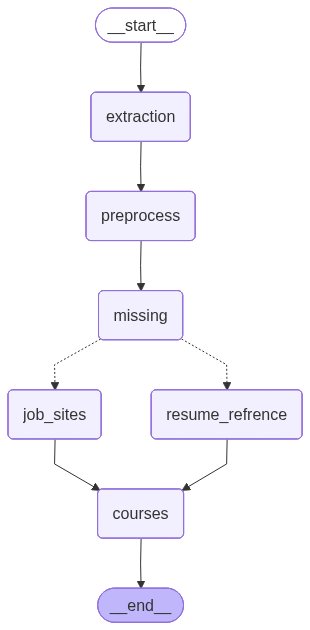

In [17]:
workflow

In [18]:
initial_state = {
    "name": "Ayush",
    "job_title": "AI Engineer",
    "experience": 0,
    "pdf_path": r"C:\AYUSH\comet\Comet_AI_Assistance\AyushSingh_AIMl_Resume_2026_compressed.pdf",
    "jd": "Looking for AI engineer with ML, Python, LLM experience",
    "email": "test@gmail.com",
    "linkedin": "https://linkedin.com/in/test"
}
config = {
    "configurable":{
        "thread_id" : "job_agent:ayush:AI:ENGINEER"
    }
}
result = workflow.invoke(initial_state, config=config)

In [21]:
# ----------------------------
# RUN WORKFLOW
# ----------------------------

result = workflow.invoke(initial_state, config=config)

# ----------------------------
# PRINT FINAL SUMMARY
# ----------------------------

print("\n================ FINAL RESULT ================\n")

print("Name:", result.get("name"))
print("Job Title:", result.get("job_title"))

print("\n--- Evaluation ---")
print("Match Score:", result.get("match_score"))
print("Overall Quality Score:", result.get("overall_quality_score"))
print("Quality Verdict:", result.get("quality_verdict"))

print("\n--- Feedback ---")
print(result.get("feedback_summary"))

print("\n--- Missing Improvements ---")
print(result.get("missing_improvements"))

print("\n--- Missing Field Explanations ---")
print(result.get("missing_field_explanations"))

# ----------------------------
# SHOW WHICH PATH EXECUTED
# ----------------------------

if result.get("ref_resume"):
    print("\nPath Taken: Weak Resume → Resume Reference → Courses")
    print("Reference Resumes:", result.get("ref_resume"))

if result.get("jobs_links"):
    print("\nPath Taken: Strong Resume → Job Sites → Courses")
    print("Job Links:", result.get("jobs_links"))

print("\n--- Suggested Courses ---")
print(result.get("courses_list"))

print("\n===============================================")


# ----------------------------
# OPTIONAL: DEBUG STEP-BY-STEP EXECUTION
# ----------------------------

print("\n\n===== DEBUG EXECUTION FLOW =====\n")

for step in workflow.stream(initial_state, config=config):
    print(step)


================ FINAL RESULT ================

Name: Ayush
Job Title: AI Engineer

--- Evaluation ---
Match Score: 10.0
Overall Quality Score: 9.5
Quality Verdict: Excellent

--- Feedback ---
✅ Strong specialization in GenAI, LLM applications, and RAG pipelines.
✅ Demonstrates practical experience with production-style systems and relevant tools (FastAPI, Docker, Vector DBs).
✅ Excellent problem-solving skills, evidenced by DSA proficiency and hackathon win.
✅ Comprehensive skill set covering Deep Learning, ML, and MLOps.

--- Missing Improvements ---
[]

--- Missing Field Explanations ---
{}

Path Taken: Weak Resume → Resume Reference → Courses
Reference Resumes: ['https://www.interviewquery.com/p/ai-engineer-resume', 'https://mentorcruise.com/resume/ai-engineer/', 'https://www.reddit.com/r/ResumeCoverLetterTips/comments/1q4m40h/i_tested_the_10_best_resume_builders_of_2026/']

Path Taken: Strong Resume → Job Sites → Courses
Job Links: ['https://www.naukri.com/ai-engineer-jobs', 'htt

In [22]:
def list_threads():
    threads = set()
    for checkpoint in checkpointer.list(None):
        threads.add(checkpoint.config["configurable"]["thread_id"])
    return list(threads)

print("Stored Threads:", list_threads())

Stored Threads: ['job_agent:ayush:AI:ENGINEER']
